# Image Denoising with Autoencoders

## Part 1: Introduction and Importing Libraries
___

In [1]:
import numpy as np

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

## Part 2: Data Preprocessing
___

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float')/255.
x_test = x_test.astype('float')/255.

x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

## Part 3: Adding Noise
___

In [3]:
x_train_noisy = x_train + np.random.rand(60000, 784) * 0.9
x_test_noisy = x_test + np.random.rand(10000, 784) * 0.9

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

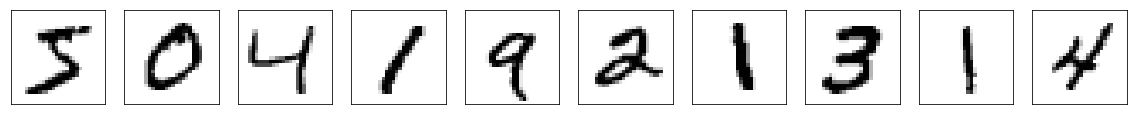

In [4]:
def plot(x, p, labels = False):
    plt.figure(figsize=(20,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i].reshape(28,28), cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if labels:
            plt.xlabel(np.argmax(p[i]))
    plt.show()
    return
plot(x_train, None)

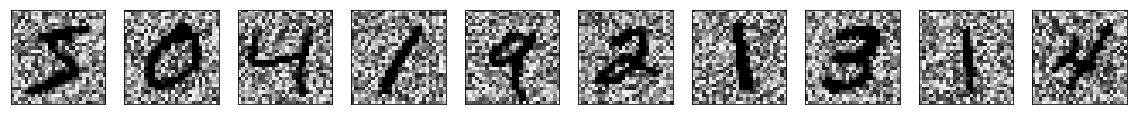

In [5]:
plot(x_train_noisy, None)

## Part 4: Building and Training a Classifier
___

In [6]:
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

classifier.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.fit(x_train, y_train, epochs=3, batch_size=512)

Epoch 1/3
60000/60000 [==============================] - 6s 105us/step - loss: 0.4333 - acc: 0.8803
Epoch 2/3
60000/60000 [==============================] - 4s 74us/step - loss: 0.1523 - acc: 0.9558
Epoch 3/3
60000/60000 [==============================] - 4s 72us/step - loss: 0.1023 - acc: 0.9701


In [7]:
loss, acc = classifier.evaluate(x_test, y_test)
print(acc)

10000/10000 [==============================] - 1s 66us/step
0.9708


In [8]:
loss, acc = classifier.evaluate(x_test_noisy, y_test)
print(acc)

10000/10000 [==============================] - 1s 54us/step
0.1746


## Part 5: Building the Autoencoder
___

In [9]:
input_image = Input(shape=(784,))
encoded = Dense(64, activation='relu')(input_image)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_image, decoded)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

## Part 6: Training the Autoencoder
___

In [10]:
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=100, batch_size=512,
    validation_split=0.2, verbose=False,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        LambdaCallback(on_epoch_end=lambda e,l: print('{:.3f}'.format(l['val_loss']), end=' _ '))
    ]
)

print(' _ ')
print('Training is complete!')

0.260 _ 0.231 _ 0.197 _ 0.182 _ 0.172 _ 0.163 _ 0.155 _ 0.148 _ 0.142 _ 0.138 _ 0.134 _ 0.131 _ 0.128 _ 0.125 _ 0.123 _ 0.121 _ 0.119 _ 0.118 _ 0.116 _ 0.115 _ 0.114 _ 0.113 _ 0.113 _ 0.112 _ 0.111 _ 0.111 _ 0.110 _ 0.110 _ 0.110 _ 0.109 _ 0.109 _ 0.109 _ 0.109 _ 0.109 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.108 _ 0.107 _ 0.108 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _ 0.107 _  _ 
Training is complete!


## Part 7: Denoised Images
___

In [11]:
preds = autoencoder.predict(x_test_noisy)

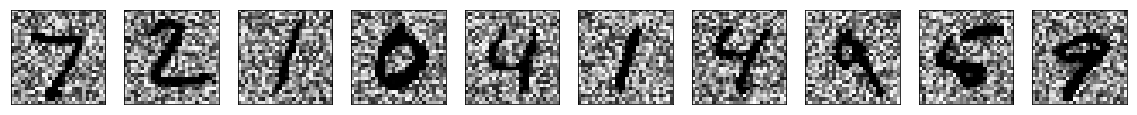

In [12]:
plot(x_test_noisy, None)

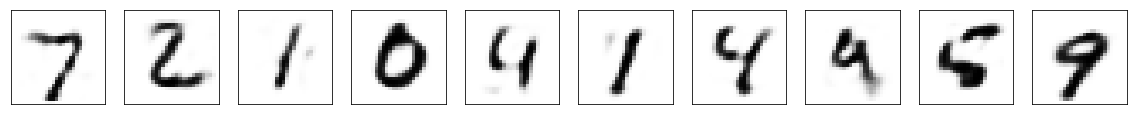

In [13]:
plot(preds, None)

In [14]:
loss, acc = classifier.evaluate(preds, y_test)
print(acc)

10000/10000 [==============================] - 1s 71us/step
0.9459


## Part 8: Composite Model
___

In [15]:
noisy_image = Input(shape=(784,))
x = autoencoder(noisy_image)
y = classifier(x)

denoise_and_classify = Model(noisy_image, y)

In [16]:
p = denoise_and_classify.predict(x_test_noisy)

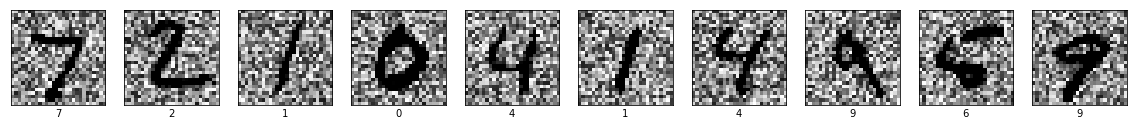

In [17]:
plot(x_test_noisy, p, True)

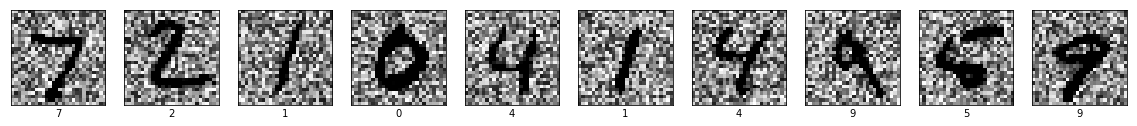

In [18]:
plot(x_test_noisy, to_categorical(y_test), True)